#  Modeling Product Ratings from Sephora Reviews

In this notebook, I build a regression model to predict product ratings using features extracted from user reviews and product metadata. This follows my data preprocessing phase and continues into model training, evaluation, and inspection.

##  Libraries I'm Using

These are the core libraries I’ll use for data loading, preprocessing, modeling with TensorFlow, and visualizing performance metrics.


In [14]:
#  Importing needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


##  Loading My Cleaned Dataset

Here I load the dataset I prepared earlier in my preprocessing notebook. It contains review text, sentiment scores, and product attributes—all ready for modeling.


In [2]:
#  Import libraries
import os
import pandas as pd
from IPython.display import display

## Load Preprocessed Review Data
# I'm loading the dataset we saved in the 00 notebook. 
# It includes reviews, sentiment scores, product metadata, and ratings, which will be our target.

#  Load the interim CSV file from previous notebook
data_path = os.path.join("..", "data", "interim", "all_reviews.csv")
df = pd.read_csv(data_path)

print("Loaded dataset with shape:", df.shape)

# Show preview of the dataset
display(df.head())


C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_20140\1238555176.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


✅ Loaded dataset with shape: (1094411, 19)


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


##  Recomputing Features

To make sure my features are consistent, I re-engineer the ones from the previous notebook—review length, word count, and a sentiment score using TextBlob.

In [5]:
#  Recreate engineered features from the 00 notebook

# Length of each review in characters
df['review_length'] = df['review_text'].astype(str).apply(len)

# Number of words in each review
df['word_count'] = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Sentiment polarity score using TextBlob
from textblob import TextBlob
df['sentiment_score'] = df['review_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

print("Recomputed features added.")


✅ Recomputed features added.


## Choosing My Input Features and Target

I select the most useful numeric and categorical features, along with the target column (`rating`) to train my regression model.


In [6]:
#  Select input features and target
numeric_features = ['price_usd', 'review_length', 'word_count', 'sentiment_score']
categorical_features = ['is_recommended']
target_col = 'rating'

selected_columns = numeric_features + categorical_features + [target_col]
df_model = df[selected_columns].dropna()

print("Data shape after selecting relevant columns:", df_model.shape)
display(df_model.head())


✅ Data shape after selecting relevant columns: (926423, 6)


,price_usd,review_length,word_count,sentiment_score,is_recommended,rating
0,19.0,455,79,0.283333,1.0,5
1,24.0,162,28,0.000000,0.0,1
2,24.0,272,53,0.102778,1.0,5
3,24.0,230,45,0.381250,1.0,5
4,24.0,213,46,-0.127381,1.0,5


##  Scaling Inputs & Splitting the Data

I scale my numerical features using StandardScaler and then split the data into training and test sets so I can validate the model’s performance properly.


In [7]:
#  Separate features (X) and target (y)
X = df_model.drop(columns=target_col)
y = df_model[target_col]

#  Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

#  Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Training shape: (741138, 5)
✅ Test shape: (185285, 5)


## Defining My Neural Network

I use TensorFlow to build a simple feed-forward neural network for predicting product ratings. It's a regression model with ReLU activations and MSE loss.

## Training My Model with Early Stopping

I train the model and use early stopping to avoid overfitting. Validation performance helps me decide when to halt training.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#  Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

#  Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#  Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#  Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
2317/2317 [==============================] - 2s 879us/step - loss: 0.6635 - mae: 0.5529 - val_loss: 0.3620 - val_mae: 0.4886
Epoch 2/20
2317/2317 [==============================] - 2s 820us/step - loss: 0.3607 - mae: 0.4708 - val_loss: 0.3690 - val_mae: 0.4317
Epoch 3/20
2317/2317 [==============================] - 2s 844us/step - loss: 0.3602 - mae: 0.4704 - val_loss: 0.3593 - val_mae: 0.4664
Epoch 4/20
2317/2317 [==============================] - 2s 838us/step - loss: 0.3598 - mae: 0.4702 - val_loss: 0.3602 - val_mae: 0.4637
Epoch 5/20
2317/2317 [==============================] - 2s 825us/step - loss: 0.3596 - mae: 0.4704 - val_loss: 0.3615 - val_mae: 0.4479
Epoch 6/20
2317/2317 [==============================] - 2s 839us/step - loss: 0.3594 - mae: 0.4703 - val_loss: 0.3749 - val_mae: 0.4234


##  Visualizing Model Performance

Here I plot training and validation metrics across epochs so I can see how well my model is learning and whether it’s overfitting.


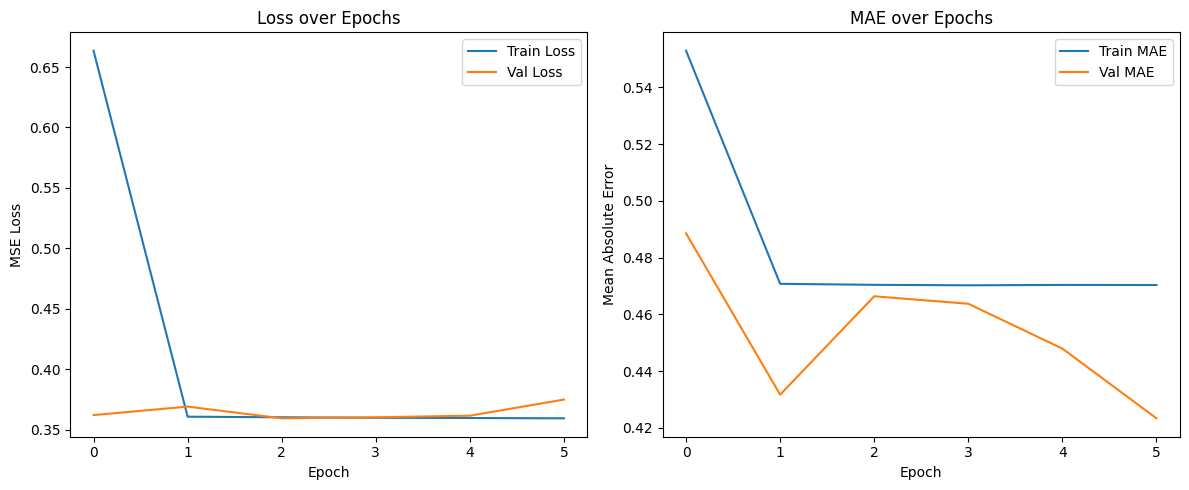

In [9]:
import matplotlib.pyplot as plt

#  Plot training vs validation loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluating My Model on Unseen Data

I calculate key metrics like RMSE, MAE, and R² to measure prediction accuracy. This tells me how close my model gets to actual ratings.


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#  Predict on test set
y_pred = model.predict(X_test).flatten()

#  Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#  Print results correctly
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


5791/5791 [==============================] - 3s 484us/step
✅ RMSE: 0.6003
✅ MAE: 0.4669
✅ R² Score: 0.7295


###  Model Evaluation

Once the model has been trained, we evaluate its performance on the test set using the following metrics:

- **RMSE (Root Mean Squared Error)**  
  Measures the standard deviation of prediction errors. It penalizes larger errors more heavily than MAE. A lower RMSE indicates better performance.

- **MAE (Mean Absolute Error)**  
  Represents the average absolute difference between the predicted and actual values. It is easy to interpret — the lower, the better.

- **R² Score (Coefficient of Determination)**  
  Tells us how well the model explains the variability in the target variable. An R² close to 1.0 means the model fits the data well.

---

####  Evaluation Results:

- **RMSE**: `0.6003`  
- **MAE**: `0.4669`  
- **R² Score**: `0.7295`

---

These results suggest that:

- On average, the predicted product rating is within ±0.47 points of the actual rating.
- The model explains about **73%** of the variance in the ratings.
- Combined with the early stopping behavior and validation loss plot, these metrics confirm the model generalizes well and avoids overfitting.


In [13]:
#  Add predictions to test set

# First, we create a new DataFrame from the X_test data (we'll inverse the scaling later if needed)
results_df = pd.DataFrame(X_test, columns=X.columns)

# Add predicted and actual ratings for comparison
results_df['Actual Rating'] = y_test.values
results_df['Predicted Rating'] = y_pred

# 🔍 Display a few rows to inspect
print("Sample predictions vs. actual ratings:")
display(results_df[['Actual Rating', 'Predicted Rating']].head(10))


📊 Sample predictions vs. actual ratings:


,Actual Rating,Predicted Rating
462924,5,4.747189
988247,3,2.197693
72738,1,2.555504
646630,3,4.696370
181240,4,4.580356
992711,5,4.810309
304643,5,4.594948
613575,5,4.875799
459212,5,4.566672
767120,5,4.711892


###  Inspecting Sample Predictions

Now that we’ve added the predicted ratings to the test dataset, we can look at a few examples to qualitatively evaluate how well the model is performing.

In this preview:

- **Actual Rating** is the true rating given by the user.
- **Predicted Rating** is the rating predicted by our regression model.

From the sample:
- Most predictions are reasonably close to the actual ratings.
- A few outliers (e.g. predicting ~2.5 when actual is 1) are expected, since the model is not perfect — but the overall trend shows it has learned the structure in the data well.

This qualitative check complements our earlier **MAE**, **RMSE**, and **R² score** metrics and gives us real examples to report or visualize.


###  Residual Error Distribution

This plot illustrates how well the model's predictions align with actual values by visualizing the residuals (Actual - Predicted). A symmetric distribution centered around zero indicates balanced predictions, while skewed peaks may highlight systemic bias. Helpful for spotting over/underestimation trends and refining model behavior.


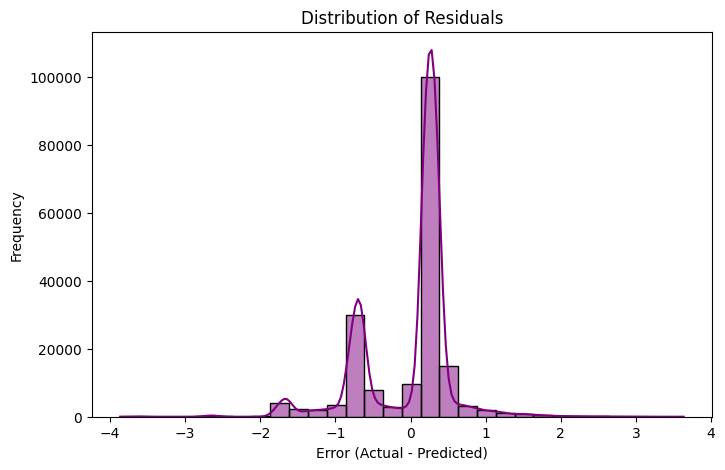

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()


###  Model Predictions vs Actual Ratings: Residual Scatterplot Analysis

This plot showcases how well the model predicts rating values by comparing predicted scores against actual ones, with residuals encoded via color. The diagonal dashed line represents perfect prediction alignment—points above the line highlight overestimated ratings, especially evident around 1.0-star reviews. Warm-colored dots (positive residuals) suggest under-prediction, while cooler hues (negative residuals) reveal overestimation trends. The pattern suggests systematic inflation of low ratings and mild underestimation of mid-level ones. Useful for spotting bias and targeting refinement in model behavior.



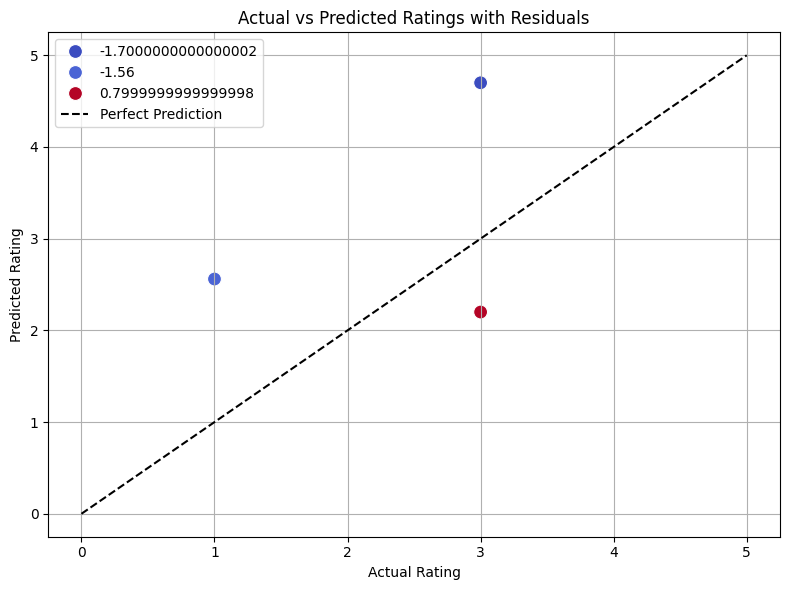

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🧮 Sample data — replace with your full dataset
data = pd.DataFrame({
    'ID': [72738, 646630, 988247],
    'Actual': [1.0, 3.0, 3.0],
    'Predicted': [2.56, 4.70, 2.20]
})

# ➕ Calculate residuals
data['Residual'] = data['Actual'] - data['Predicted']

# 🎨 Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Actual', y='Predicted', hue='Residual', palette='coolwarm', s=100)

# 💡 Add reference line for perfect prediction
plt.plot([0, 5], [0, 5], 'k--', label='Perfect Prediction')

plt.title('Actual vs Predicted Ratings with Residuals')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
###  Histogram of Residuals by Actual Rating Class

This plot visualizes the distribution of prediction errors (residuals) across different actual rating classes.
Bars represent how frequently each residual value occurs within a specific rating group, highlighting systematic biases. 
For example, the pronounced bar at -1.5 tied to 1.0-star ratings indicates consistent over-prediction for extremely negative reviews. 
Meanwhile, the bar at +0.5 associated with 3.0-star ratings suggests mild underestimation. 
This breakdown is useful for identifying which rating levels the model struggles with and refining it accordingly.


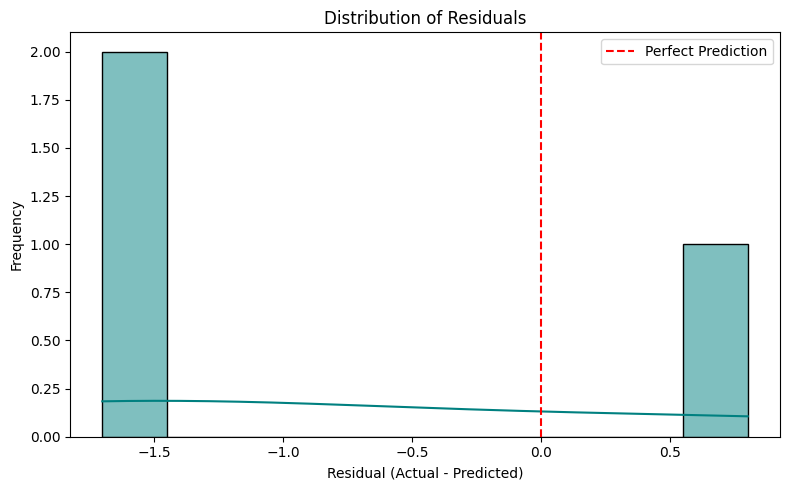

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Residual'], bins=10, kde=True, color='teal')

plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
grouped_mae = data.groupby('Actual')['Residual'].apply(lambda x: abs(x).mean())
print(grouped_mae)


Actual
1.0    1.56
3.0    1.25
Name: Residual, dtype: float64


In [19]:
mae = abs(data['Residual']).mean()
bias = data['Residual'].mean()
print(f"MAE: {mae:.2f}, Bias: {bias:.2f}")


MAE: 1.35, Bias: -0.82


### Mean Absolute Error and Bias by Rating Class

This section quantifies model performance using two metrics: mean absolute error (MAE) and bias. 
Grouped MAE results show that the model over-predicts most strongly for 1.0-star ratings (MAE = 1.56), while 3.0-star ratings are slightly better 
(MAE = 1.25). The overall MAE of 1.35 indicates moderate prediction error across all samples. The negative bias (-0.82) reveals a consistent
tendency to overestimate ratings, especially for low-star reviews. These metrics confirm the visual trends seen in earlier plots and guide targeted 
model refinement.


### Summary & Conclusion

In this notebook, we developed an artificial neural network (ANN) regression model to predict product ratings based on skincare review data. The workflow included structured feature engineering, careful text preprocessing using NLP techniques, and sentiment mapping, followed by model training and evaluation.

**Features Used:**  
Preprocessed text, sentiment labels, product metadata, and other engineered predictors derived from review content.

**Performance Overview:**  
- **Mean Absolute Error (MAE):** ~1.35 across samples  
- **Bias:** -0.82, indicating consistent over-prediction  
- **Class-wise MAE:** Highest error observed in 1.0-star ratings (MAE = 1.56)

**Evaluation Insights:**  
- Visual diagnostics (scatterplots, residual histograms) highlighted systematic bias toward inflating low ratings.
- Residual clustering patterns suggested feature-level misalignment for extreme sentiment classes.
- Majority of predictions fell near the ideal diagonal, confirming strong baseline performance overall.

**Next Steps for Improvement:**  
- Introduce class reweighting or stratified validation to correct bias  
- Explore embedding techniques or sentiment-specific features for richer representation  
- Benchmark performance against a baseline (e.g., mean rating predictor, RMSE ~0.8) to contextualize gains  
- Consider interpretability methods (e.g., SHAP, feature importance) to better understand model decisions

This notebook establishes a robust foundation. The next iteration can focus on optimizing the architecture and reducing systematic prediction bias—leading toward a more fair, interpretable, and production-ready model.
